In [21]:
import requests
import pandas as pd
import os
from bs4 import BeautifulSoup
from urllib import parse
import logging
import re

stripedoc = 'data/stripe-pages.csv'
appdirectdoc = 'data/appdirect-pages.csv'
stripe_url = 'https://stripe.com'
appdirect_url = 'https://www.appdirect.com'
cols = ['url', 'status', 'title', 'heading', 'text', 'word_count', 'num_links', 'link_text', 'link_word_count', 'description', 'keywords']
hrefs_to_skip = ['#', 'javascript:', 'mailto:', '.rss', '.pdf', '.xml', '.svg']

visited_urls = []
urls_to_visit = []

logging.basicConfig(
    format='%(asctime)s %(levelname)s:%(message)s',
    level=logging.INFO)

def init_archive():
    df = pd.DataFrame(columns = cols)
    os.makedirs("data", exist_ok=True)
    df.to_csv(stripedoc)

def load_csv_archive():
    return pd.read_csv(stripedoc)

def save_csv_archive(df):
    os.makedirs("data", exist_ok=True)
    df.to_csv(stripedoc, index=False)

def add_links(links):
    for link in links:
        #print(link)
        href = link.get('href')
        # prepend starting url to relative url
        if href[0] == '/':
            href = parse.urljoin(stripe_url, href)
        # don't add urls that are in the hrefs_to_skip list
        if any(skippable in href for skippable in hrefs_to_skip):
            continue
        # ignore anything not in domain
        if not href.startswith(stripe_url):
            continue
        # if we haven't already visited it and it's not already on our list to visit
        if href not in urls_to_visit and href not in visited_urls:
            urls_to_visit.append(href)


def process_page(url):
    try:
        page = requests.get(url)
    except Exception:
        logging.exception(f'Failed to crawl: {url}')
        pass
    status = page.status_code
    soup = BeautifulSoup(page.content, 'html.parser')

    title = soup.find('title').get_text()
    
    description = None if soup.find('meta', property='description') is None else soup.find('meta', property='description').get('content')
    keywords = None if soup.find('meta', property='keywords') is None else soup.find('meta', property='keywords').get('content')

    if '/docs' in url:
        real_content = soup.find('article', id='content')
        heading = soup.find('h1', class_='Title')
        if real_content is not None:
            text = real_content.get_text(" ")
            all_links = real_content.find_all('a', href=True)
        else:
            text = soup.get_text(strip=True)
            all_links = soup.find_all('a', href=True)

    if '/newsroom' in url:
        real_content = soup.find('article', class_='Section')
        heading = soup.find('h1', class_='NewsroomPost__title')
        if real_content is not None:
            text = real_content.get_text(" ")
            all_links = real_content.find_all('a', href=True)
        else:
            text = soup.get_text(strip=True)
            all_links = soup.find_all('a', href=True)

    else:
        real_content = soup.find_all('section', class_='Section')
        heading = soup.find('h1', class_='Copy__title')
        text = ''
        for section in real_content:
            text += ' '.join(section.get_text(" ").split()) + ' '
        all_links = []
        for section in real_content:
            for link in section.find_all('a', href=True):
                all_links.append(link)

    word_count = len(text.split())
    num_links = len(all_links)

    link_text = ''
    for link in all_links:
        link_text += ' '.join(link.get_text(" ").split()) + ' '

    link_word_count = len(link_text.split())

    # add urls to lists:
    if len(all_links) > 0:
        add_links(all_links)
    
    return { 'url': url,
            'status': status,
            'title': title, 
            'heading': heading, 
            'text': text, 
            'word_count': word_count, 
            'num_links': num_links, 
            'link_text': link_text, 
            'link_word_count': link_word_count,
            'description': description,
            'keywords': keywords }

In [22]:
init_archive()
df = load_csv_archive()

def run():
    first_page = process_page(stripe_url)
    new_row = pd.Series(first_page).to_frame().T
    df = pd.concat([load_csv_archive(), new_row], ignore_index=True)
    save_csv_archive(df)

    while urls_to_visit:
        url = urls_to_visit.pop(0)
        visited_urls.append(url)
        logging.info(f'Crawling: {url}')
        row = process_page(url)
        updated = pd.concat([load_csv_archive(), pd.Series(row).to_frame().T], ignore_index=True)
        save_csv_archive(updated)



run()


2023-07-18 06:53:31,829 INFO:Crawling: https://stripe.com/contact/sales
2023-07-18 06:53:33,311 INFO:Crawling: https://stripe.com/atlas
2023-07-18 06:53:34,720 INFO:Crawling: https://stripe.com/billing
2023-07-18 06:53:36,422 INFO:Crawling: https://stripe.com/capital
2023-07-18 06:53:38,562 INFO:Crawling: https://stripe.com/payments/checkout
2023-07-18 06:53:40,260 INFO:Crawling: https://stripe.com/climate
2023-07-18 06:53:41,959 INFO:Crawling: https://stripe.com/connect
2023-07-18 06:53:43,488 INFO:Crawling: https://stripe.com/payments/elements
2023-07-18 06:53:44,996 INFO:Crawling: https://stripe.com/identity
2023-07-18 06:53:46,401 INFO:Crawling: https://stripe.com/invoicing
2023-07-18 06:53:48,074 INFO:Crawling: https://stripe.com/issuing
2023-07-18 06:53:49,443 INFO:Crawling: https://stripe.com/payments
2023-07-18 06:53:51,076 INFO:Crawling: https://stripe.com/radar
2023-07-18 06:53:53,263 INFO:Crawling: https://stripe.com/sigma
2023-07-18 06:53:55,600 INFO:Crawling: https://strip

AttributeError: 'NoneType' object has no attribute 'get_text'

In [23]:
stripe = load_csv_archive()
stripe.drop('Unnamed: 0', inplace=True, axis=1)

stripe.describe()


,status,word_count,num_links,link_word_count,description,keywords
count,1285.000000,1285.000000,1285.000000,1285.000000,0.0,0.0
mean,200.952529,1483.031128,20.937743,69.477821,NaN,NaN
std,13.912558,3884.818144,31.306009,216.964313,NaN,NaN
min,200.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,200.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,200.000000,588.000000,11.000000,45.000000,NaN,NaN
75%,200.000000,1390.000000,28.000000,81.000000,NaN,NaN
max,404.000000,48589.000000,318.000000,5973.000000,NaN,NaN


In [25]:
c = stripe[stripe.word_count != 0]
c = c[c.status == 200]
c = c[c['url'].str.contains("/legal") == False]
c = c[c['url'].str.contains('/open-source-notices') == False]

print("MINS")
print(c[c.word_count == c.word_count.min()].url.values)
print("MAXS")
print(c[c.word_count == c.word_count.max()].url.values)
print("MEDIAN")
print(c.median(numeric_only=True)['word_count'])

c.describe()


MINS
['https://stripe.com/blog/building-stripe-tax'
 'https://stripe.com/blog/stripe-sessions-2023'
 'https://stripe.com/blog/improving-instant-payouts'
 'https://stripe.com/blog/how-we-built-it-stripe-radar'
 'https://stripe.com/blog/new-elements-features'
 'https://stripe.com/blog/crypto-onramp' 'https://stripe.com/blog/markdoc'
 'https://stripe.com/blog/new-and-improved-stripe-terminal'
 'https://stripe.com/blog/reimagining-bank-transfers'
 'https://stripe.com/blog/stripe-sessions-2022'
 'https://stripe.com/blog/migrating-to-typescript'
 'https://stripe.com/blog/sessions-is-back-on-may-24'
 'https://stripe.com/blog/creator-economy'
 'https://stripe.com/blog/atlas-first-five-years'
 'https://stripe.com/blog/sessions-keynote-2021'
 'https://stripe.com/blog/fast-secure-builds-choose-two'
 'https://stripe.com/blog/sorbet-stripes-type-checker-for-ruby'
 'https://stripe.com/blog/why-some-businesses-arent-allowed'
 'https://stripe.com/blog/stripe-sessions-2021'
 'https://stripe.com/blog/op

,status,word_count,num_links,link_word_count,description,keywords
count,762.0,762.000000,762.000000,762.000000,0.0,0.0
mean,200.0,1663.107612,24.612861,86.712598,NaN,NaN
std,0.0,3771.853813,32.244524,266.737460,NaN,NaN
min,200.0,48.000000,1.000000,1.000000,NaN,NaN
25%,200.0,455.250000,11.000000,29.000000,NaN,NaN
50%,200.0,811.500000,13.000000,49.000000,NaN,NaN
75%,200.0,1551.000000,26.000000,73.000000,NaN,NaN
max,200.0,39884.000000,318.000000,5973.000000,NaN,NaN


<Axes: title={'center': 'Stripe.com Word Counts'}, ylabel='Frequency'>

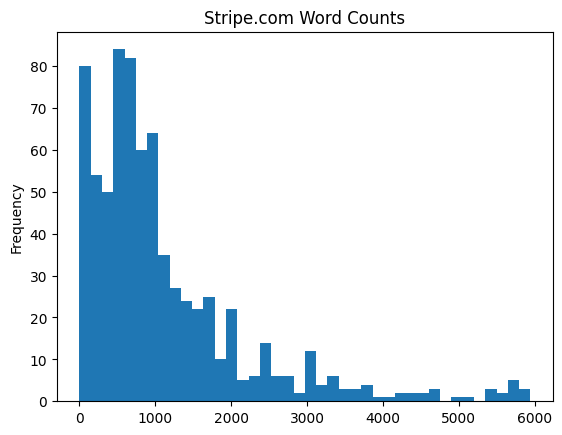

In [31]:
c = c[c.word_count < 6000]
c.plot(kind="hist", title="Stripe.com Word Counts", xlabel="Num of Words", ylabel="Num of Pages", column='word_count', bins=40, legend=False)
#c.describe()

C:\Users\dhoer\AppData\Local\Temp\ipykernel_30724\2817542446.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  c['path'] = c['url'].str.replace("https://stripe.com", '')


<Axes: ylabel='count of pages'>

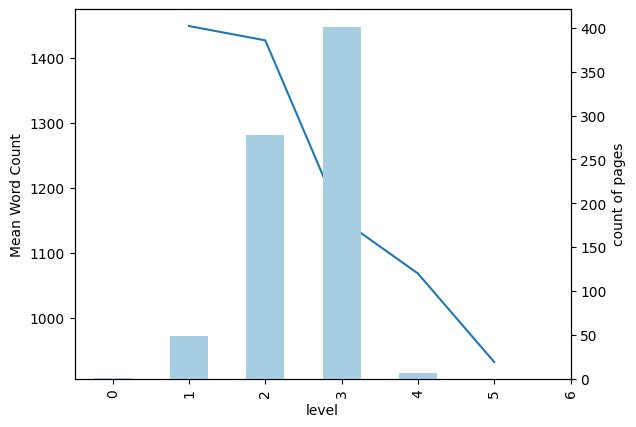

In [58]:
c['path'] = c['url'].str.replace("https://stripe.com", '')
c['level'] = c['path'].str.split('/').str.len()

c.groupby('level').mean(numeric_only=True)['word_count'].plot(xticks=[0, 1, 2, 3, 4, 5, 6], ylabel="Mean Word Count", xlabel="page level")
c.groupby('level').count()['word_count'].plot(xticks=[0, 1, 2, 3, 4, 5, 6], secondary_y=True, ylabel="count of pages", kind="bar",  colormap='Paired') 



Is there any correlation between level and count?